<a href="https://colab.research.google.com/github/bruno774/mestrado/blob/master/AlemDaPena_p3_Kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## preliminaries

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt


In [2]:
from sklearn.cluster import KMeans
from sklearn import metrics


In [8]:
!pip show scikit-learn


Name: scikit-learn
Version: 0.22.2.post1
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: None
Author-email: None
License: new BSD
Location: /usr/local/lib/python3.7/dist-packages
Requires: scipy, numpy, joblib
Required-by: yellowbrick, sklearn, sklearn-pandas, mlxtend, lightgbm, librosa, imbalanced-learn


In [ ]:
data_src = pd.read_pickle('alemPena-p2.pickle')

In [ ]:
data_num = data_src.to_numpy()

## finding best K for k-means

In [3]:
from yellowbrick.cluster import KElbowVisualizer

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function calinski_harabaz

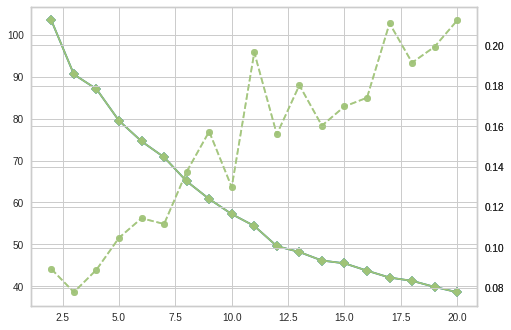

In [ ]:
#https://www.scikit-yb.org/en/latest/api/cluster/elbow.html

model=KMeans()
visualizer = KElbowVisualizer(model, k=20, metric='calinski_harabaz')

visualizer.fit(data_src)
visualizer.draw()
#visualizer.show()

## dimension reduction with PCA

In [ ]:
#pcav = PCA().fit(data_src)
#plt.plot(np.cumsum(pcav.explained_variance_ratio_))

De acordo com o gráfico acima, que ilustra a evolução da representatividade da quantidade de autovetores usados para descrever um conjunto de dados (representados no eixo X), identifica que acima de 15 autovetores a representação do domínio original atinge valores maiores q cerca de 90% da informação representada.

"Principal component analysis (PCA).

Linear dimensionality reduction using Singular Value Decomposition of the
data to project it to a lower dimensional space. The input data is centered
but not scaled for each feature before applying the SVD.

It uses the LAPACK implementation of the full SVD or a randomized truncated
SVD by the method of Halko et al. 2009, depending on the shape of the input
data and the number of components to extract."

In [ ]:
#pca = PCA(n_components=31)
#pca_src = pca.fit_transform(data_src)

Estratégia descartada dado a grande quantidade de atributos que, pelos critérios de representatividade, seriam necessários para estar acima de 80% da significância incluiriam mais de 20 colunas

## K-means

In [4]:
from scipy.spatial import distance

In [ ]:
class Kmeansv2():
    def __init__(self, k=3, tos=0.0001, n_iter=300):
        self.k = k
        self.tos = tos
        self.n_iter = n_iter

    def fit(self, data, n_iter=300, tos = 0.0001):
        self.centroids = {}
        for i in range(self.k):
            self.centroids[i] = data[i]

        for i in range(n_iter):
            self.clusters = {}
            for i in range(self.k):
                self.clusters[i] = []
        
            #vrow=[1,1]
            # distance measure for each point
            for row in data:
                #distances = [np.linalg.norm(row - self.centroids[centroid]) for centroid in self.centroids]
                #distances = [distance.chebyshev(row, self.centroids[centroid]) for centroid in self.centroids]
                distances = [distance.chebyshev(row, self.centroids[centroid]) for centroid in self.centroids]
                cluster = distances.index(min(distances))
                self.clusters[cluster].append(row)

            previous_centroids = dict(self.centroids)
            for cluster in self.clusters:
                self.centroids[cluster] = np.average(self.clusters[cluster], axis=0)

            # Check if tolerance was reached
            centroids_changed = True
            for centroid in self.centroids:
                difference = np.sum((self.centroids[centroid] - previous_centroids[centroid])/previous_centroids[centroid]*100.0)               
                if  difference > tos:
                    centroids_changed = False

            if centroids_changed:
                break

    def predict(self, data):
        distances = [distance.chebyshev(data, self.centroids[centroid]) for centroid in self.centroids]
        cluster = distances.index(min(distances))
        return cluster

## multiple running for statistical analysis

In [ ]:
# chebyshev cityblock cosine euclidean hamming jaccard mahalanobis minkowski
hcMetric='chebyshev'
# GeneroReu ou CondSocialCirc
hcClasse='CondSocialCirc'

In [ ]:
maxIter = 30

ext=[0.0]*maxIter
acc=[0.0]*maxIter
arc=[0.0]*maxIter
sls=[0.0]*maxIter
chs=[0.0]*maxIter
mis=[0.0]*maxIter
fms=[0.0]*maxIter

In [ ]:

for i in range(maxIter):  
    t0 = time.time()
    model = Kmeansv2(k=3)
    model.fit(data_num, n_iter=300, tos=0.0001)
    cluster_distance = model.clusters

    cluster_labels_predict=[]
    for pdt in data_num:
        cluster_labels_predict.append(model.predict(pdt))
    
    t1 = time.time()
    ext[i]=(t1-t0)
    
    acc[i]=metrics.accuracy_score(data_src[hcClasse], cluster_labels_predict)
    arc[i]=metrics.adjusted_rand_score(data_src[hcClasse], cluster_labels_predict)
    sls[i]=metrics.silhouette_score(data_src, cluster_labels_predict, metric=hcMetric)
    chs[i]=metrics.calinski_harabasz_score(data_src, cluster_labels_predict)
    mis[i]=metrics.mutual_info_score(data_src[hcClasse], cluster_labels_predict)
    fms[i]=metrics.fowlkes_mallows_score(data_src[hcClasse], cluster_labels_predict)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/pytho

## performance analysis

In [ ]:
print("KMeans - Class:",hcClasse,"- metric:", hcMetric)

print("ExecTime mean: ",np.mean(ext))
print("Accuracy mean: ",np.mean(acc))
print("Rand Score mean: ",np.mean(arc))
print("Silhouette mean: ",np.mean(sls))
print("Calinki-Harabasz mean: ",np.mean(chs))
print("Mutual Info mean: ",np.mean(mis))
print("Fowlkes Mallows mean: ",np.mean(fms))

print("\nExecTime median: ",np.median(ext))
print("Accuracy median: ",np.median(acc))
print("Rand Score median: ",np.median(arc))
print("Silhouette median: ",np.median(sls))
print("Calinki-Harabasz median: ",np.median(chs))
print("Mutual Info median: ",np.median(mis))
print("Fowlkes Mallows median: ",np.median(fms))

print("\nExecTime Std: ",np.std(ext))
print("Accuracy Std: ",np.std(acc))
print("Rand Score Std: ",np.std(arc))
print("Silhouette Std: ",np.std(sls))
print("Calinki-Harabasz Std: ",np.std(chs))
print("Mutual Info Std: ",np.std(mis))
print("Fowlkes Mallows Std: ",np.std(fms))

KMeans - Class: CondSocialCirc - metric: chebyshev
ExecTime mean:  0.0768403689066569
Accuracy mean:  0.7937293729372935
Rand Score mean:  -0.04592565676890833
Silhouette mean:  0.0255368805078335
Calinki-Harabasz mean:  7.848830804702118
Mutual Info mean:  0.00665220752968809
Fowlkes Mallows mean:  0.8080001194806451

ExecTime median:  0.07532751560211182
Accuracy median:  0.7937293729372937
Rand Score median:  -0.045925656768908314
Silhouette median:  0.02553688050783349
Calinki-Harabasz median:  7.848830804702118
Mutual Info median:  0.006652207529688089
Fowlkes Mallows median:  0.8080001194806449

ExecTime Std:  0.0072410450069879005
Accuracy Std:  2.220446049250313e-16
Rand Score Std:  1.3877787807814457e-17
Silhouette Std:  1.0408340855860843e-17
Calinki-Harabasz Std:  0.0
Mutual Info Std:  8.673617379884035e-19
Fowlkes Mallows Std:  2.220446049250313e-16


In [ ]:
#cluster_labels_predict

In [ ]:
import seaborn as sns
default_font_size = rcParams['font.size']
rcParams['font.size'] = 20
rcParams['axes.labelsize']=20
rcParams['axes.titlesize']=20
rcParams['figure.figsize'] =(8.0, 5.5)

# ['Male','Female','Other']
categ = ['No','Yes','Other']

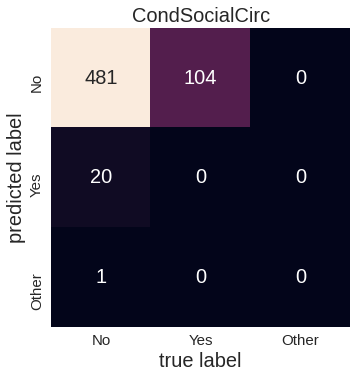

In [ ]:
mat = metrics.confusion_matrix(data_src[hcClasse], cluster_labels_predict)

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, 
            xticklabels=categ, yticklabels=categ)

plt.tick_params(labelsize=15)
plt.title(hcClasse)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

In [ ]:
model.centroids

{0: array([0.06837607, 0.86324786, 0.16752137, 0.82905983, 0.35897436,
        0.16239316, 0.17777778, 0.12307692, 0.15897436, 0.24273504,
        0.17948718, 0.12991453, 0.17948718, 0.24786325, 0.55187377,
        0.14820197, 0.06391453, 0.03565417, 0.47692308, 0.25470085,
        0.26837607, 0.13333333, 0.01367521, 0.01538462, 0.01709402,
        0.51623932, 0.1008547 , 0.12307692, 0.02051282, 0.05982906]),
 1: array([0.        , 1.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 1.        , 0.65      ,
        0.08123077, 0.00916667, 0.        , 1.        , 0.        ,
        0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]),
 2: array([0.        , 1.        , 0.        , 1.        , 1.        ,
        0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 1.        , 0. 

In [ ]:
rcParams.values

<bound method Mapping.values of RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': True,
          'axes.edgecolor': '.8',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext

##Visual Analysis: Clusters versus Gender/CondSocialCirc

In [ ]:
df = pd.DataFrame(list(model.centroids.values()))

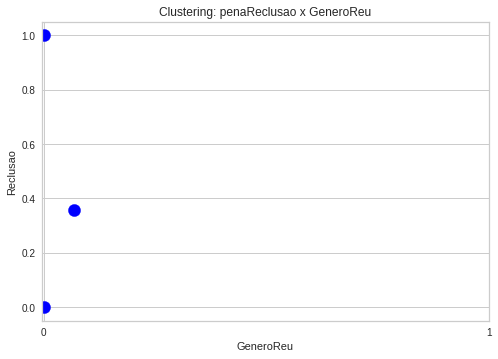

In [ ]:
plt.scatter(df[0], df[4], s=150, c = 'blue')
plt.title('Clustering: penaReclusao x GeneroReu')
plt.xlabel('GeneroReu')
plt.ylabel('Reclusao')
plt.xticks(range(0,2))
plt.show()

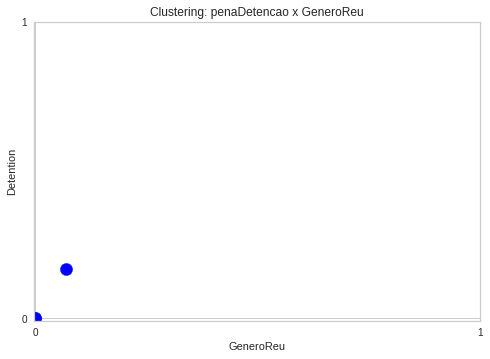

In [ ]:
plt.scatter(df[0], df[2], s=150, c = 'blue')
plt.title('Clustering: penaDetencao x GeneroReu')
plt.xlabel('GeneroReu')
plt.ylabel('Detention')
plt.xticks(range(0,2))
plt.yticks(range(0,2))
plt.show()

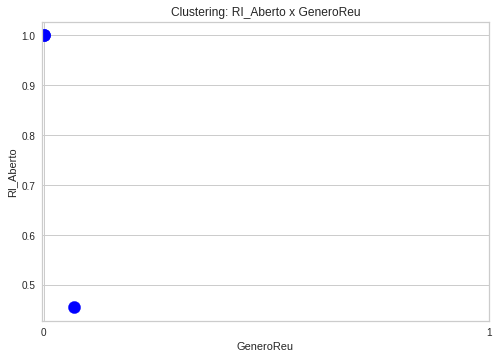

In [ ]:
plt.scatter(df[0], df[18], s=150, c = 'blue')
plt.title('Clustering: RI_Aberto x GeneroReu')
plt.xlabel('GeneroReu')
plt.ylabel('RI_Aberto')
plt.xticks(range(0,2))
plt.show()

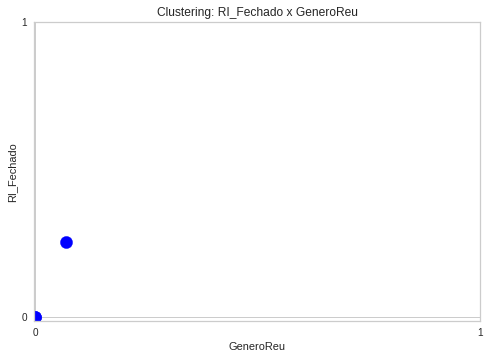

In [ ]:
plt.scatter(df[0], df[19], s=150, c = 'blue')
plt.title('Clustering: RI_Fechado x GeneroReu')
plt.xlabel('GeneroReu')
plt.ylabel('RI_Fechado')
plt.xticks(range(0,2))
plt.yticks(range(0,2))
plt.show()

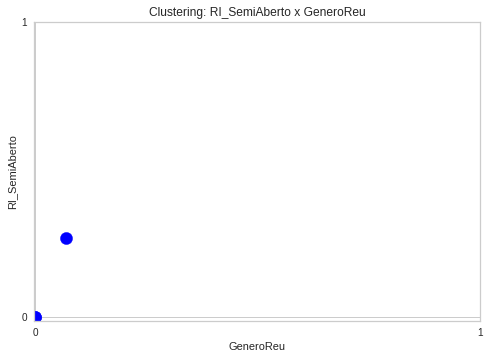

In [ ]:
plt.scatter(df[0], df[21], s=150, c = 'blue')
plt.title('Clustering: RI_SemiAberto x GeneroReu')
plt.xlabel('GeneroReu')
plt.ylabel('RI_SemiAberto')
plt.xticks(range(0,2))
plt.yticks(range(0,2))
plt.show()

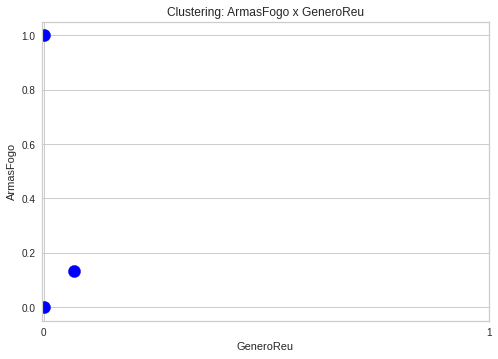

In [ ]:
plt.scatter(df[0], df[22], s=150, c = 'blue')
plt.title('Clustering: ArmasFogo x GeneroReu')
plt.xlabel('GeneroReu')
plt.ylabel('ArmasFogo')
plt.xticks(range(0,2))
plt.show()

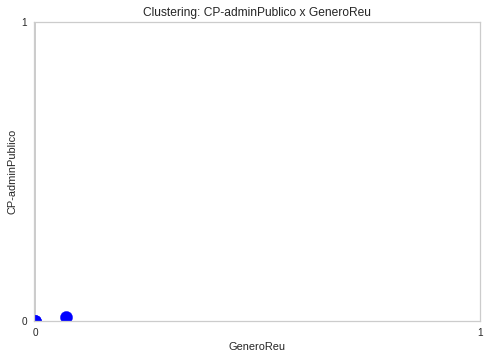

In [ ]:
plt.scatter(df[0], df[23], s=150, c = 'blue')
plt.title('Clustering: CP-adminPublico x GeneroReu')
plt.xlabel('GeneroReu')
plt.ylabel('CP-adminPublico')
plt.xticks(range(0,2))
plt.yticks(range(0,2))
plt.show()

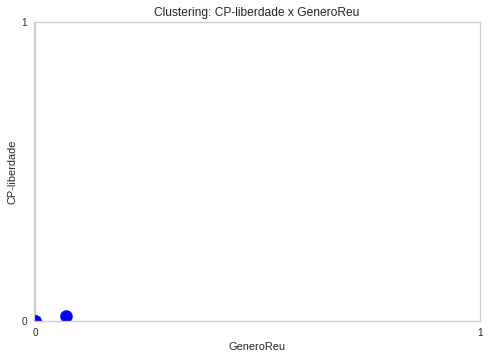

In [ ]:
plt.scatter(df[0], df[24], s=150, c = 'blue')
plt.title('Clustering: CP-liberdade x GeneroReu')
plt.xlabel('GeneroReu')
plt.ylabel('CP-liberdade')
plt.xticks(range(0,2))
plt.yticks(range(0,2))
plt.show()

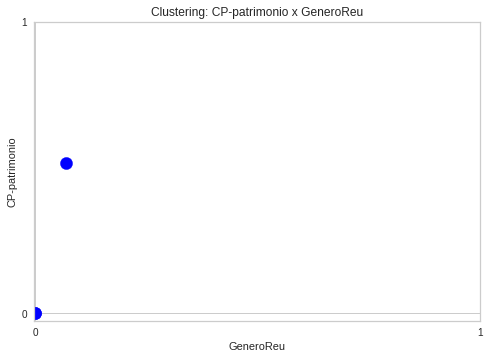

In [ ]:
plt.scatter(df[0], df[26], s=150, c = 'blue')
plt.title('Clustering: CP-patrimonio x GeneroReu')
plt.xlabel('GeneroReu')
plt.ylabel('CP-patrimonio')
plt.xticks(range(0,2))
plt.yticks(range(0,2))
plt.show()

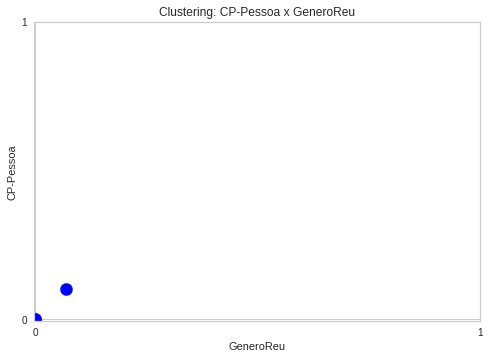

In [ ]:
plt.scatter(df[0], df[27], s=150, c = 'blue')
plt.title('Clustering: CP-Pessoa x GeneroReu')
plt.xlabel('GeneroReu')
plt.ylabel('CP-Pessoa')
plt.xticks(range(0,2))
plt.yticks(range(0,2))
plt.show()

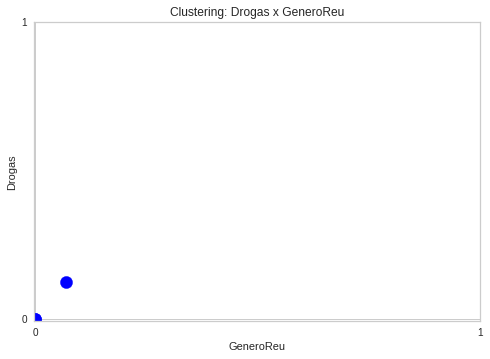

In [ ]:
plt.scatter(df[0], df[28], s=150, c = 'blue')
plt.title('Clustering: Drogas x GeneroReu')
plt.xlabel('GeneroReu')
plt.ylabel('Drogas')
plt.xticks(range(0,2))
plt.yticks(range(0,2))
plt.show()

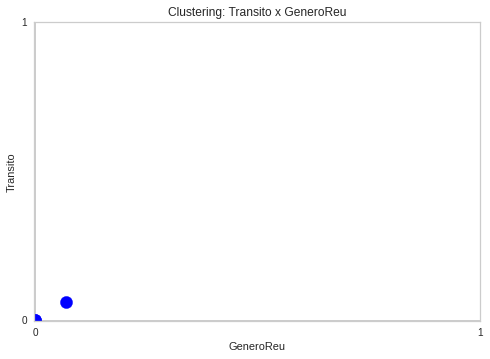

In [ ]:
plt.scatter(df[0], df[30], s=150, c = 'blue')
plt.title('Clustering: Transito x GeneroReu')
plt.xlabel('GeneroReu')
plt.ylabel('Transito')
plt.xticks(range(0,2))
plt.yticks(range(0,2))
plt.show()

In [ ]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, 12))

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

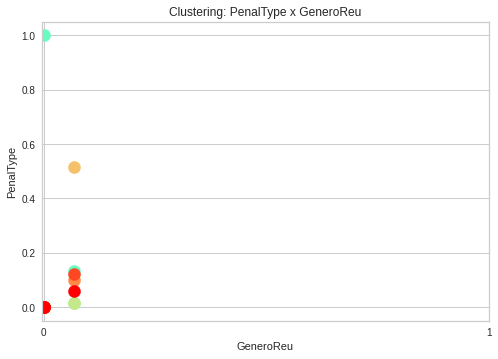

In [ ]:
plt.scatter(df[0], df[22], s=150, c = colors[5])
plt.scatter(df[0], df[23], s=150, c = colors[6])
plt.scatter(df[0], df[24], s=150, c = colors[7])
plt.scatter(df[0], df[26], s=150, c = colors[8])
plt.scatter(df[0], df[27], s=150, c = colors[9])
plt.scatter(df[0], df[28], s=150, c = colors[10])
plt.scatter(df[0], df[30], s=150, c = colors[11])

plt.title('Clustering: PenalType x GeneroReu')
plt.xlabel('GeneroReu')
plt.ylabel('PenalType')
plt.xticks(range(0,2))

plt.show()

A apresentação do gráfico acima, mesclando os clusters de todos os tipos penais, sugere que todos os clusters seguem a influência das amostras masculinas (observar que foi convencionado que Gender=0 é masculino), indicando que todos os tipos penais analisados são mais sentenciados à reus homens ou, mais explicado, que o desbalanceamento dos dados para casos em que os reus são homens (9/1) domina a definição de clusters pelo algoritmo.